In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns; sns.set()
import zipfile

In [2]:
train = "order_products__train"
products = 'products'
departments = 'departments'
aisles = 'aisles'
prior= "order_products__prior"
orders='orders'
path="/content/drive/MyDrive/Data_btp2/"
orders = zipfile.ZipFile(path+orders+".zip","r")
products = zipfile.ZipFile(path+products+".zip","r")
departments = zipfile.ZipFile(path+departments+".zip","r")
aisles = zipfile.ZipFile(path+aisles+".zip","r")
train = zipfile.ZipFile(path+train+".zip","r")
prior=zipfile.ZipFile(path+prior+".zip","r")

In [3]:
train = pd.read_csv(train.open('order_products__train.csv'))
prior =pd.read_csv(prior.open('order_products__prior.csv'))
products = pd.read_csv(products.open('products.csv'))
departments = pd.read_csv(departments.open('departments.csv'))
aisles = pd.read_csv(aisles.open('aisles.csv'))
orders = pd.read_csv(orders.open('orders.csv'))

In [4]:
# appending train with prior to obtain whole sample size 
full = prior.append(train)

In [5]:
# sorting values by order id to keep some structure
full.sort_values(by = 'order_id', inplace = True, kind = 'mergesort')

In [6]:
# merging orders and full to include time and product information
full= full.merge(orders, on = 'order_id', how = 'left')

In [7]:
# merging to substitute id for actual name
full = full.merge(products, on = 'product_id', how = 'left')

In [8]:
# merging to substitute id for actual name
full = full.merge(aisles, on = 'aisle_id', how = 'left')

In [9]:
# merging to substitute id for actual name
full = full.merge(departments, on = 'department_id', how = 'left')

In [10]:
# removing id in place of actual name 
full.pop('product_id')
full.pop('aisle_id')
full.pop('department_id')
full.head()

order_id  add_to_cart_order  ...                 aisle    department
0         1                  1  ...                yogurt    dairy eggs
1         1                  2  ...  other creams cheeses    dairy eggs
2         1                  3  ...      fresh vegetables       produce
3         1                  4  ...      fresh vegetables       produce
4         1                  5  ...   canned meat seafood  canned goods

[5 rows x 12 columns]

In [11]:
# reordering sequence of columns for easy lookup
full = full[[ 'order_id',
             'order_number',
             'user_id',
             'department',
             'aisle',
             'product_name',
             'add_to_cart_order',
             'days_since_prior_order',
             'order_dow',
             'order_hour_of_day',
             'reordered',
             'eval_set']]
full.head()

order_id  order_number  user_id  ... order_hour_of_day reordered eval_set
0         1             4   112108  ...                10         1    train
1         1             4   112108  ...                10         1    train
2         1             4   112108  ...                10         0    train
3         1             4   112108  ...                10         0    train
4         1             4   112108  ...                10         1    train

[5 rows x 12 columns]

In [12]:
# EDA

Text(0.5, 1.0, 'What department is purchased from the most?')

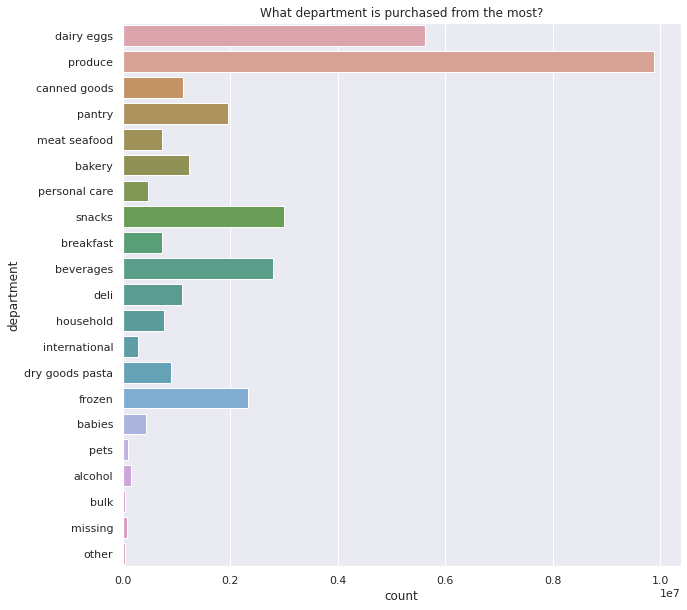

In [13]:
# How can we classify the items? produce offers the most
# Will this be evident in the recommended products?
plt.figure(figsize = (10,10))
sns.countplot(
            y = 'department',
            data = full,  
            orient = 'h', 
            saturation = 0.5,
            )
plt.title('What department is purchased from the most?')

In [14]:
# How many products are there?
total_products = products.shape[0]
total_products

49688

In [15]:
# How many aisles?
total_aisles = aisles.shape[0]
total_aisles

134

In [16]:
# How many departments?
total_departments = departments.shape[0]
total_departments

21

In [17]:
# creation of data for department and aisle comparison 
stock = full[['department', 'aisle', 'product_name']]
# changed from series to df to input into graph
total_units = pd.DataFrame(stock.groupby(['department','aisle']).size().sort_values())
# renaming unnamed column
total_units.reset_index(inplace = True)
total_units.rename(columns = { 0:'totals'}, inplace = True)
total_units.head()

department                aisle  totals
0         frozen         frozen juice    5147
1  personal care               beauty    6455
2         babies     baby accessories    8466
3         babies  baby bath body care    8909
4  personal care         eye ear care    9522

In [18]:
full.loc[(full['aisle'] == 'missing') | (full['department'] == 'missing')]
# 77396 observations contain "missing"  
# because of the 1258 products containing "missing" in aisle and/or department column

order_id  order_number  ...  reordered eval_set
654             75             1  ...          0    prior
1511           154            68  ...          1    prior
1512           154            68  ...          0    prior
2126           226             4  ...          0    train
4121           420            37  ...          0    prior
...            ...           ...  ...        ...      ...
33816839   3420851            79  ...          1    train
33816856   3420852            40  ...          0    prior
33818714   3421036            21  ...          0    prior
33818837   3421050            31  ...          0    prior
33818925   3421059             7  ...          0    prior

[77396 rows x 12 columns]

In [19]:
# visualization for better interpretation and quicker comparisons
fig, ax = plt.subplots(figsize=(20,65), dpi= 325)
# Initial setup for the background
ax.hlines(
          y=total_units.aisle, 
          color='gray', 
          xmin=350, 
          xmax=1050, 
          alpha=0.3,
          linewidth=2,
          linestyles='dashdot'
          )

plot_kws = {'s':500}
# controls marker size passed down to plt.scatter at draw time
sns.scatterplot(
            x= 'totals',
            y='aisle',
            hue='department', 
            data=total_units, 
            palette= 'colorblind', 
            **plot_kws
           )

# Title, Label, Ticks and Legend

ax.set_title(
            'Product Aisle Items',
             fontdict={'size':63}
            )
plt.legend(
           loc = 'lower right',
           prop={'size': 50},
           markerscale = 5
          )

# x axis
ax.set_xlim(0, 1300)
ax.set_xlabel('Items Available', fontdict={'size':50})
ax.set_xticklabels([0,200,400,600,800,1000,1200], fontdict = {'size': 36})
ax.tick_params(axis = 'x', labelsize = 50, which = 'major')

# y axis
ax.tick_params(axis = 'y', labelsize = 25, which ='major')
plt.ylabel('Aisle', fontdict = {'size':21})
ax.set_yticks(total_units.aisle)
ax.set_yticklabels(total_units.aisle.str.title(),
                   fontdict={'horizontalalignment': 'right'})



plt.show()

In [20]:
# top 20 products sold
top_20_items = full.product_name.value_counts().head(20)
top_20_items

Banana                      491291
Bag of Organic Bananas      394930
Organic Strawberries        275577
Organic Baby Spinach        251705
Organic Hass Avocado        220877
Organic Avocado             184224
Large Lemon                 160792
Strawberries                149445
Limes                       146660
Organic Whole Milk          142813
Organic Raspberries         142603
Organic Yellow Onion        117716
Organic Garlic              113936
Organic Zucchini            109412
Organic Blueberries         105026
Cucumber Kirby               99728
Organic Fuji Apple           92889
Organic Lemon                91251
Organic Grape Tomatoes       88078
Apple Honeycrisp Organic     87272
Name: product_name, dtype: int64

Text(0.5, 1.0, 'What items are the most purchased?')

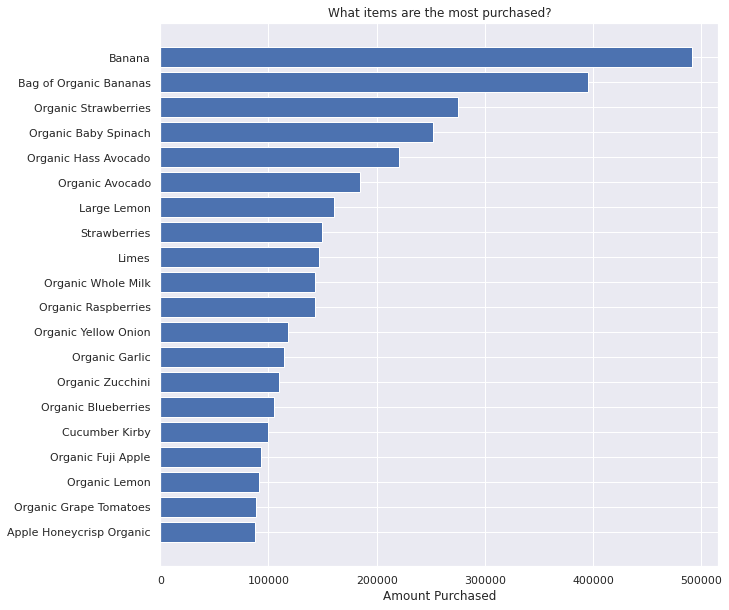

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(
    top_20_items.index,
    top_20_items, 
    align='center'
        )
# labels read top-to-bottom
ax.invert_yaxis() 
ax.set_xlabel('Amount Purchased')
ax.set_title('What items are the most purchased?')

In [22]:
# What items are reordered the most? only a few slight differences
reordered_amt = full.loc[full['reordered'] == 1].groupby('product_name').size()
reordered_amt.sort_values(inplace = True, ascending = False)
top_20_reordered = reordered_amt.head(20)

Text(0.5, 1.0, 'What items are reordered the most ?')

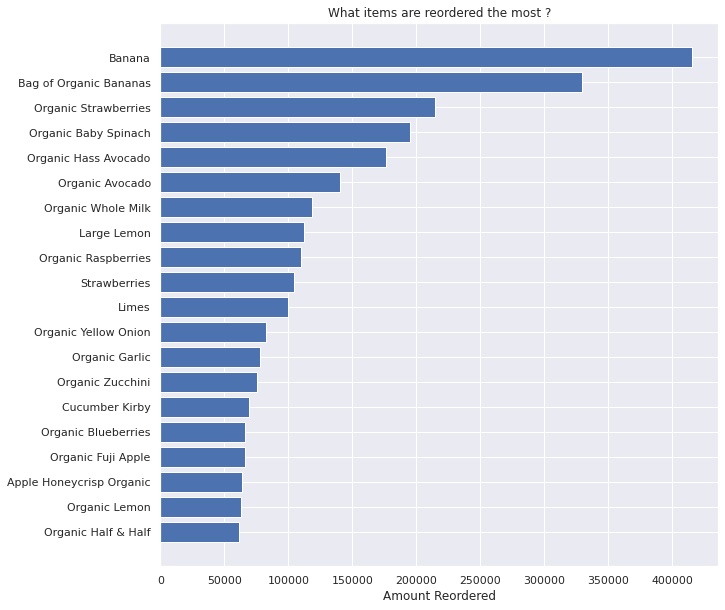

In [23]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(top_20_reordered.index, top_20_reordered, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Amount Reordered')
ax.set_title('What items are reordered the most ?')

In [24]:
#What items are usually chosen first?
first_picks = full.loc[full['add_to_cart_order'] == 1].groupby('product_name').size()
first_picks.sort_values(inplace = True, ascending = False)
first_picks_top_20 = first_picks.head(20)

Text(0.5, 1.0, 'What items are chosen first?')

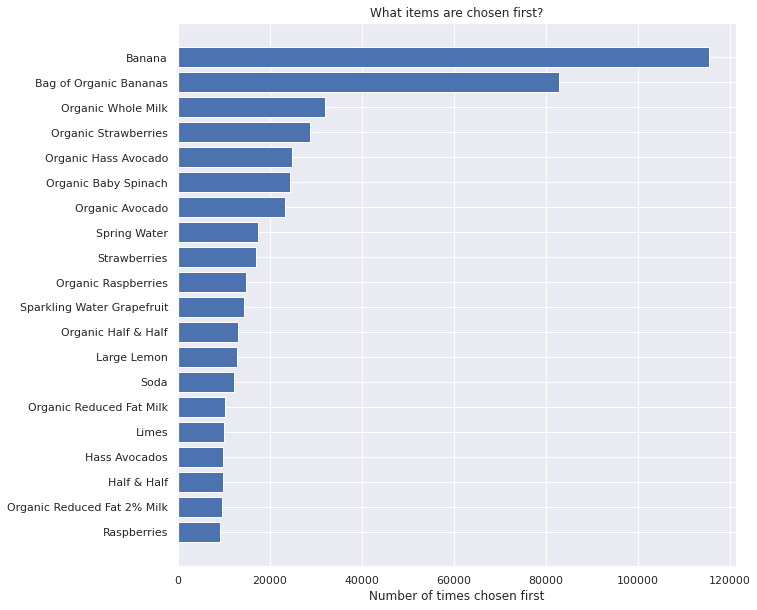

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(first_picks_top_20.index,first_picks_top_20, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of times chosen first')
ax.set_title('What items are chosen first?')

In [26]:
# How often is a product reordered
reorder_ratio = full.reordered.value_counts()

Text(0, 0.5, '')

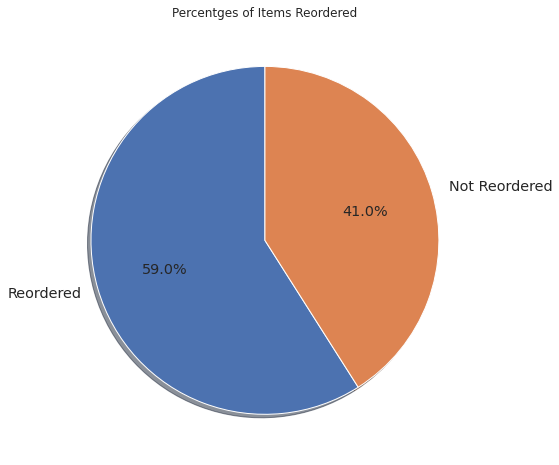

In [27]:
# Plotting pie chart, kwargs draws from pyplot.pie
pie_kwargs = {'startangle': 90, 
              'labels' : ['Reordered','Not Reordered'],
              'autopct' : '%.1f%%',
               'fontsize' : 'x-large'
             }
reorder_ratio.plot(kind = 'pie', 
                   figsize = (8,8),
                   title = 'Percentges of Items Reordered',
                   shadow = True,
                   **pie_kwargs).set_ylabel('')

In [28]:
# order amount per user
order_amt = full.groupby('user_id').order_number.max()
order_amt

user_id
1         11
2         15
3         12
4          5
5          5
          ..
206205     4
206206    67
206207    16
206208    49
206209    14
Name: order_number, Length: 206209, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(17.226658390273947, 0.08, 'mean = 16.23')

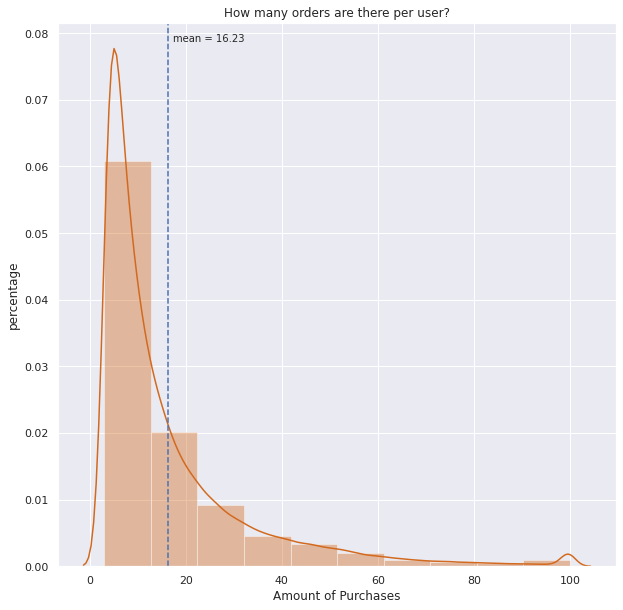

In [29]:
# order amount per user
plt.figure(figsize = (10,10))
sns.distplot(
            order_amt, 
            kde = True, 
            bins = 10, 
            color = 'chocolate', 
            axlabel = 'Amount of Purchases',
            )
plt.title('How many orders are there per user?')
plt.ylabel('percentage')
plt.axvline(order_amt.mean(), linestyle='dashed',)
plt.text(
    order_amt.mean() + 1,
    0.08,
    'mean = ' + str(round(order_amt.mean(), 2)),
    verticalalignment = 'top'
    )

In [30]:
# amount of items purchased in each order
items_per_purchase = full.groupby('order_id').add_to_cart_order.max()
items_per_purchase

order_id
1           8
2           9
3           8
4          13
5          26
           ..
3421079     1
3421080     9
3421081     7
3421082     7
3421083    10
Name: add_to_cart_order, Length: 3346083, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(18, 0.06, 'mean = 10.11')

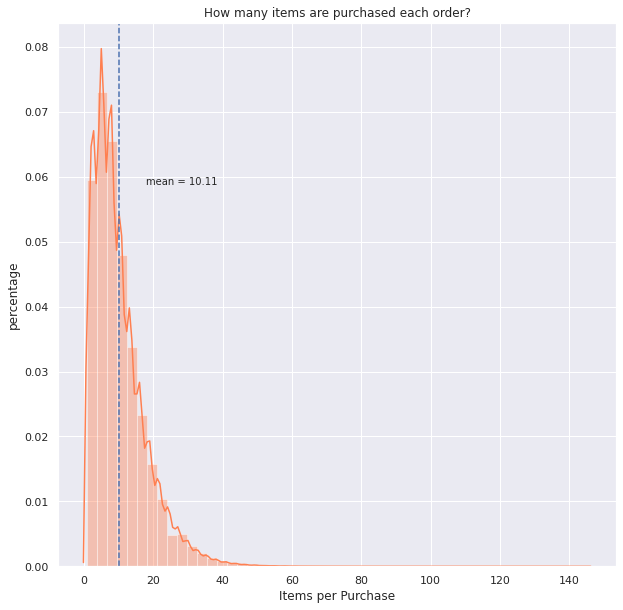

In [31]:
# items per purchase
plt.figure(figsize = (10,10))
sns.distplot(
            items_per_purchase, 
            kde = True, 
            color = 'coral', 
            axlabel = 'Items per Purchase',
            )

plt.title('How many items are purchased each order?')
plt.ylabel('percentage')
plt.axvline(items_per_purchase.mean(), linestyle='dashed',)
plt.text(18,
         0.06,
         'mean = '+ str(round(items_per_purchase.mean(), 2)),
         verticalalignment = 'top'
        )

In [32]:
days_since_means = full.groupby('user_id').days_since_prior_order.mean()
days_since_means

user_id
1         19.200000
2         18.009390
3         11.487179
4         15.357143
5         12.314286
            ...    
206205    14.705882
206206     4.042705
206207    14.879397
206208     7.442105
206209    20.903226
Name: days_since_prior_order, Length: 206209, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(17.631327395640753, 0.06, 'mean = 15.63')

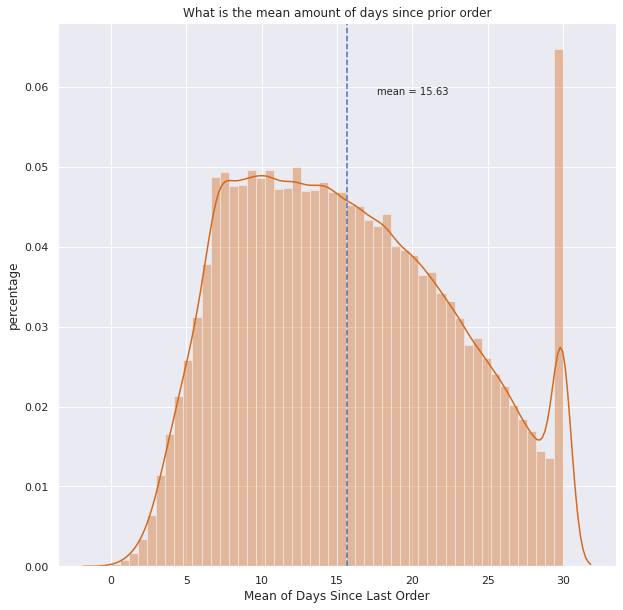

In [33]:
# items per purchase
plt.figure(figsize = (10,10))
sns.distplot(
            days_since_means, 
            kde = True, 
            color = 'chocolate', 
            axlabel = 'Mean of Days Since Last Order',
            )
plt.title('What is the mean amount of days since prior order')
plt.ylabel('percentage')
plt.axvline(days_since_means.mean(), linestyle='dashed',)
plt.text(days_since_means.mean() + 2,
         0.06,
         'mean = '+ str(round(days_since_means.mean(), 2)),
         verticalalignment = 'top'
        )

Text(0, 0.5, 'mean number of days since prior order')

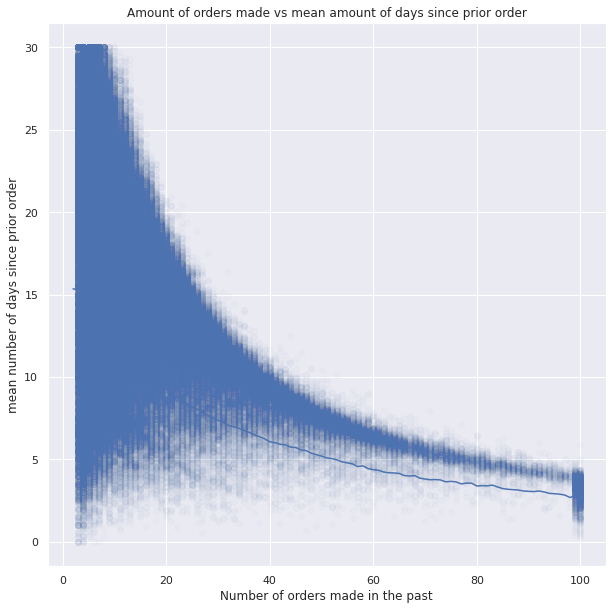

In [34]:
# scatterplot do the amount of days since person relate to the amount of orders made
plt.figure(figsize = (10,10))

plt.scatter(order_amt, days_since_means,  marker = 'o', alpha = 0.02)
plt.plot(
    orders.order_number.value_counts().index,
    orders.groupby('order_number').days_since_prior_order.mean(),
    color = 'b')
plt.title('Amount of orders made vs mean amount of days since prior order')
plt.xlabel('Number of orders made in the past')
plt.ylabel('mean number of days since prior order')

In [35]:
order_times = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].agg("count").reset_index()
order_times = order_times.pivot('order_hour_of_day', 'order_dow','order_number')
order_times

order_dow              0      1      2      3      4      5      6
order_hour_of_day                                                 
0                   3936   3674   3059   2952   2642   3189   3306
1                   2398   1830   1572   1495   1512   1672   1919
2                   1409   1105    943    953    899   1016   1214
3                    963    748    719    654    686    841    863
4                    813    809    744    719    730    910    802
5                   1168   1607   1399   1355   1330   1574   1136
6                   3329   5370   4758   4562   4401   4866   3243
7                  12410  16571  13245  12396  12493  13434  11319
8                  28108  34116  24635  22553  21814  24015  22960
9                  40798  51908  36314  32312  31409  34232  30839
10                 48465  55671  39230  36040  35034  38313  35665
11                 51035  51584  38128  35215  33857  37915  36994
12                 51443  47079  35780  33455  32249  35714  37121
13                 53849  46728  36650  34161  32751  36296  37564
14                 54552  46764  37173  34773  33625  37407  38748
15                 53954  46403  37469  35990  34222  37508  38093
16                 49463  44761  37541  35273  34093  35860  35562
17                 39753  36792  32151  30368  29378  29955  30398
18                 29572  28977  26470  25001  24425  24310  24157
19                 22654  22145  20084  19249  19350  18741  18346
20                 18277  16281  15039  13795  14186  13322  13392
21                 14423  11943  10653  10278  10796   9515  10501
22                 11246   8992   8146   8242   8812   7498   8532
23                  6887   5620   5358   5181   5645   5265   6087

Text(0.5, 1.0, 'Time of the Day vs. Day of the Week')

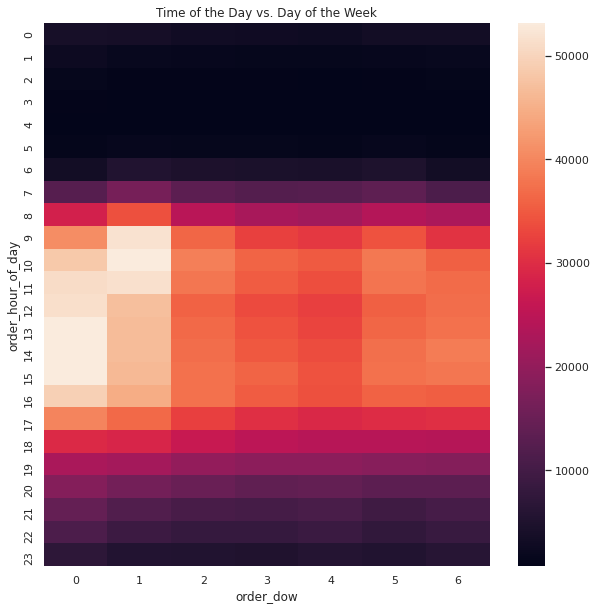

In [36]:
# time of day vs day of week heatmap
plt.figure(figsize = (10,10))
sns.heatmap(order_times, robust = True)
plt.title("Time of the Day vs. Day of the Week")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'What day has the most orders?')

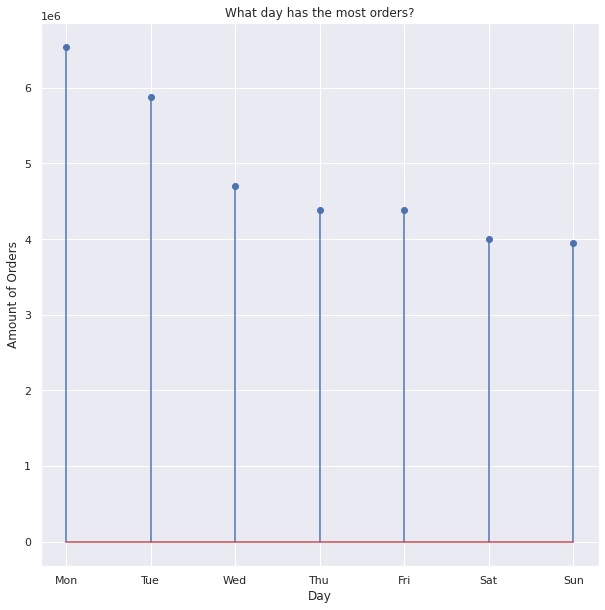

In [37]:
# How do the days compare to one another?
dow = full.order_dow.value_counts()
plt.figure(figsize = (10,10))
plt.stem(dow)
plt.xlabel('Day')
plt.ylabel('Amount of Orders')
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('What day has the most orders?')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


Text(0, 0.015, ' 10% of orders')

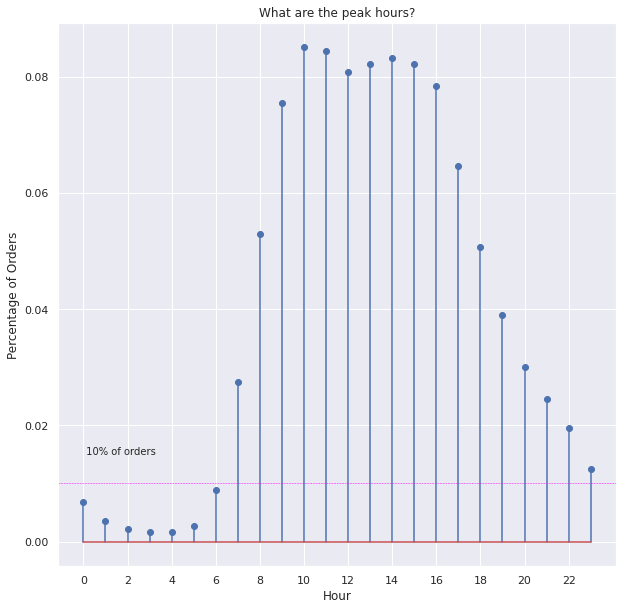

In [38]:
# How do the hours of the day compare?
time_of_day = full.order_hour_of_day.value_counts(normalize = True).sort_index()
plt.figure(figsize = (10,10))
plt.stem(time_of_day)
plt.xlabel('Hour')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
plt.ylabel('Percentage of Orders')
plt.title('What are the peak hours?')
plt.axhline(y = 0.01, linewidth = 0.5, linestyle = '--', color = 'magenta' )
plt.text(x = 0, y = 0.015, s = ' 10% of orders')

In [39]:
# Organic foods seem very popular
organic_yn = full[['order_id', 'product_name', 'reordered']]
organic_yn['Is it organic?'] = organic_yn['product_name'].str.contains('Organic', case = False)
organic_yn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


order_id  ... Is it organic?
0                1  ...          False
1                1  ...           True
2                1  ...           True
3                1  ...          False
4                1  ...          False
...            ...  ...            ...
33819101   3421083  ...          False
33819102   3421083  ...           True
33819103   3421083  ...          False
33819104   3421083  ...          False
33819105   3421083  ...           True

[33819106 rows x 4 columns]

In [40]:
# How many purchases are organic?
organic_yn['Is it organic?'].value_counts()

False    23162774
True     10656332
Name: Is it organic?, dtype: int64

In [41]:
# creating a table used to consolidate and plot reorder vs organic 
organic_table = organic_yn.pivot_table(
    'order_id',
    'Is it organic?',
    'reordered',
    aggfunc = 'count'
    )
organic_table

reordered             0         1
Is it organic?                   
False           9978312  13184462
True            3885434   6770898

Text(0.5, 1.0, 'Do organic foods get reordered more often?')

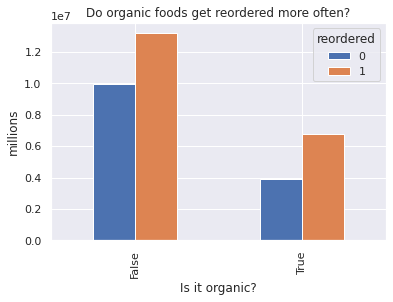

In [42]:
organic_table.plot(kind = 'bar')
plt.ylabel('millions')
plt.title('Do organic foods get reordered more often?')